In [ ]:
from datasets import load_dataset
from transformers import AutoProcessor, AutoModel, BitsAndBytesConfig
from transformers import LlavaForConditionalGeneration, LlavaNextProcessor, LlavaNextForConditionalGeneration, LlavaOnevisionForConditionalGeneration
from transformers import  Qwen2VLForConditionalGeneration,  MllamaForConditionalGeneration   
from PIL import Image

from math_llava_functions import *

# MATH PUMA IMPORTS
from qwen2 import Qwen2vlmProcessor, Qwen2vlmForConditionalGeneration

# JANUS IMPORTS
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

import torch
import pandas as pd
import re
from collections import defaultdict
import numpy as np
from sklearn.metrics import accuracy_score

from PIL import Image
import matplotlib.pyplot as plt

from qwen_vl_utils import process_vision_info

import pickle

import matplotlib as mpl
import matplotlib.font_manager as font_manager


# Matplot lib formatting
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

In [ ]:
## SELECT THE MODEL VERSION YOU WANT TO GET EMBEDDINGS FOR. 
model_version = 'math-puma'

# Load LLAVA model and processor
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16)
  
if model_version == '1.6':
    processor = AutoProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
    model = LlavaNextForConditionalGeneration.from_pretrained(
        "llava-hf/llava-v1.6-mistral-7b-hf", quantization_config=bnb_config, torch_dtype=torch.float16, low_cpu_mem_usage=True
    )

elif model_version == '1.5':
    processor = AutoProcessor.from_pretrained('llava-hf/llava-1.5-7b-hf')
    model = LlavaForConditionalGeneration.from_pretrained(
        'llava-hf/llava-1.5-7b-hf', quantization_config=bnb_config
    )

elif model_version == 'qwen':
    processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-7B-Instruct", torch_dtype=torch.float16, quantization_config=bnb_config, low_cpu_mem_usage=True
    )

elif model_version == 'internvl':
    path = "OpenGVLab/InternVL2-8B"
    processor=AutoProcessor.from_pretrained(path)
    model = AutoModel.from_pretrained(
        path,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
        low_cpu_mem_usage=True,
    ) 
    instruction_tokens = "<image>\n"
    end_tokens = ""
    
    
elif model_version == 'llava-one':
        processor = AutoProcessor.from_pretrained("llava-hf/llava-onevision-qwen2-7b-ov-hf") 
        model = LlavaOnevisionForConditionalGeneration.from_pretrained("llava-hf/llava-onevision-qwen2-7b-ov-hf", torch_dtype=torch.float16, quantization_config=bnb_config, low_cpu_mem_usage=True
        )
        instruction_tokens = ""
        end_tokens = ""
        
elif model_version == 'llama-3.2':
        processor = AutoProcessor.from_pretrained("ruslanmv/Llama-3.2-11B-Vision-Instruct")
        model = MllamaForConditionalGeneration.from_pretrained(
            "ruslanmv/Llama-3.2-11B-Vision-Instruct", torch_dtype=torch.float16, quantization_config=bnb_config, low_cpu_mem_usage=True
        )
        instruction_tokens = ""
        end_tokens = ""

elif model_version == 'math-puma':
        # Load model and processor in float16
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = Qwen2vlmForConditionalGeneration.from_pretrained(
            "Math-PUMA/Math-PUMA_Qwen2VL-7B",
            low_cpu_mem_usage=True,
            device_map="auto",
            torch_dtype=torch.float16
        )

        model.half()
        
        # Things that make inference faster....
        torch.backends.cudnn.benchmark = True
        model = torch.compile(model, mode="max-autotune")

        processor = Qwen2vlmProcessor.from_pretrained("Math-PUMA/Math-PUMA_Qwen2VL-7B")    
        instruction_tokens=""
        end_tokens=""
                
elif model_version == 'janus':
    model_path = "deepseek-ai/Janus-Pro-7B"
    processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
    model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
        model_path, trust_remote_code=True
    )
    model = model.to(torch.bfloat16).cuda().eval()
    instruction_tokens = ""
    end_tokens = ""
    instruction_tokens=""
    end_tokens=""
    
elif model_version in ['math-llava', 'g-llava']:
        if model_version == 'math-llava':
            model_path = "Zhiqiang007/Math-LLaVA"
        
        elif model_version == 'g-llava':
            model_path = "renjiepi/G-LLaVA-7B"
        
        model_base = None  # If fine-tuning, change this
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Configure quantization
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4'
        )
        
        # Load model
        if "llava" in model_path.lower():
            model = LlavaLlamaForCausalLM.from_pretrained(
                model_path,
                low_cpu_mem_usage=True,
                quantization_config=quantization_config,
                device_map="auto"
            )
        else:
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                low_cpu_mem_usage=True,
                quantization_config=quantization_config,
                device_map="auto"
            )
        
        # Load the tokenizer separately
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        
        image_processor = None
        
        if "llava" in model_path.lower():
            mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
            mm_use_im_patch_token = getattr(model.config, "mm_use_im_patch_token", True)
            
            if mm_use_im_patch_token:
                tokenizer.add_tokens(["<im_patch>"], special_tokens=True)
            if mm_use_im_start_end:
                tokenizer.add_tokens(["<im_start>", "<im_end>"], special_tokens=True)
            
            model.resize_token_embeddings(len(tokenizer))
        
            vision_tower = model.get_vision_tower()
            if hasattr(vision_tower, "load_model"):
                vision_tower.load_model()
            
            vision_tower.to(device=device, dtype=torch.float16)
            image_processor = vision_tower.image_processor
        
        # Set max context length
        context_len = getattr(model.config, "max_sequence_length", 2048)
        
        processor = {
            "tokenizer": tokenizer,
            "image_processor": image_processor,
            "context_len": context_len
        }
        
        instruction_tokens = ""
        end_tokens = ""
        
elif model_version == 'molmo':
    model = AutoModelForCausalLM.from_pretrained("cyan2k/molmo-7B-D-bnb-4bit", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("cyan2k/molmo-7B-D-bnb-4bit", trust_remote_code=True)
    instruction_tokens = ""
    end_tokens = ""    
        
# NOTE: some of the models are set up to just processes vision embeddings. 
# Other use hooks to get vision embedding. 

In [ ]:
## INTERN-VL Utils

import torchvision.transforms as T

from torchvision.transforms.functional import InterpolationMode
import ast
from io import BytesIO


IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

## GET EMBEDDINGS FUNCTIONS

In [ ]:
# load DF:


# Make sure the background is the same color!
sample_df = df[df['background_color'] == 'black']
# Remove circle from the DF.
sample_df = sample_df[sample_df["shape"] != 'circle']

# Set target count to the number of samples you want for each shape.
target_count = 162
sample_df = (
    sample_df.groupby('shape')  # Group by 'shape'
    .apply(lambda x: x.sample(n=target_count, random_state=42) if len(x) >= target_count else None)  # Sample or skip
    .reset_index(drop=True)  # Reset index after sampling
) 

def get_llava_embeddings(model, processor, sample_df, model_version='1.5'):
    hidden_states = {}
    for shape in list(set(df["shape"].values)):
        hidden_states[shape] = []
    
    for idx, row in sample_df.iterrows():
        image = Image.open(base_path + row['path'])
        pixel_values = processor.image_processor(images=image, return_tensors='pt').pixel_values
        if model_version in ['1.6', 'llava-one']:
            image_num_patches = [1]
            _pixel_values_list = [pix_val[:num_patch] for pix_val, num_patch in zip(pixel_values, image_num_patches)]
            pixel_values = torch.cat(_pixel_values_list, dim=0)
        #hidden_states[row['shape']].append(model.vision_tower(pixel_values)['pooler_output'].detach().cpu().to(torch.float32).numpy())
        hidden_states[row['shape']].append(torch.mean(model.vision_tower(pixel_values)['last_hidden_state'], dim=1).detach().cpu().to(torch.float32).numpy())
    return hidden_states
    
def get_qwen_embeddings(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(df["shape"].values)):
        hidden_states[shape] = []
        
    for idx, row in sample_df.iterrows():  
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image":row['path'],
                        #"max_pixels": max_pixels,
                        #"min_pixels": min_pixels,
                    },
                    {"type": "text", "text": "None"},
                ],
            }
        ]

        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)

        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=None,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(model.device)
        pixel_values = inputs["pixel_values"].type(torch.bfloat16)
        with torch.no_grad():
            image_embeds = model.visual(pixel_values, grid_thw=inputs["image_grid_thw"])
            
        hidden_states[row['shape']].append(torch.unsqueeze(torch.mean(image_embeds, dim=0), dim=0).detach().cpu().to(torch.float32).numpy())
    
    return hidden_states

def get_internvl_embeddings(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(df["shape"].values)):
        hidden_states[shape] = []
    
    for idx, row in sample_df.iterrows():
        image_path = base_path + row['path']
        pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
        states = model.vision_model(pixel_values).last_hidden_state
        hidden_states[row['shape']].append(torch.mean(states, dim=1).squeeze().detach().cpu().to(torch.float32).numpy())
    return hidden_states

def get_llava_one_embeddings(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(sample_df["shape"].values)):
        hidden_states[shape] = []

    for idx, row in sample_df.iterrows():
        raw_image=Image.open(base_path + row['path'])
        if raw_image.size[0] < 28 or raw_image.size[1] < 28:
            print(f"Image too small: {raw_image.size}, resizing to minimum dimensions.")
            raw_image = raw_image.resize((max(28, raw_image.size[0]), max(28, raw_image.size[1])))

        conversation = [{
                "role": "user",
                "content": [
                    {"type":"image"}],
                    },
                ]
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)


        inputs = processor(
            text=prompt,   
            images=raw_image,
                return_tensors="pt",
            ).to(model.device, torch.float16 if model.device.type == "cuda" else torch.float32)

        pixel_values = inputs.pixel_values

        image_num_patches = [1]
        _pixel_values_list = [pix_val[:num_patch] for pix_val, num_patch in zip(pixel_values, image_num_patches)]
        pixel_values = torch.cat(_pixel_values_list, dim=0)

        image_embeds = model.vision_tower(pixel_values, return_dict=True).last_hidden_state#.shape
        hidden_states[row['shape']].append(torch.mean(image_embeds, dim=1).detach().cpu().to(torch.float32).numpy())
        print(row['shape'])
    return hidden_states
        
def get_llama_embeddings(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(sample_df["shape"].values)):
        hidden_states[shape] = []
    
    for idx, row in sample_df.iterrows():
        raw_image=Image.open(base_path + row['path'])

        if raw_image.size[0] < 28 or raw_image.size[1] < 28:
            print(f"Image too small: {raw_image.size}, resizing to minimum dimensions.")
            raw_image = raw_image.resize((max(28, raw_image.size[0]), max(28, raw_image.size[1])))

        inputs = processor.image_processor(
                images=raw_image,
                return_tensors="pt",
            )
        inputs.pop('num_tiles')

        hidden_state = model.vision_model(**inputs).last_hidden_state
        img_embeds = torch.mean(hidden_state.squeeze(), dim=(0, 1)).detach().cpu().to(torch.float32).numpy()
        hidden_states[row['shape']].append(img_embeds)
        
    return hidden_states

def get_llama_embeddings_hs(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(sample_df["shape"].values)):
        hidden_states[shape] = []
    
    for idx, row in sample_df.iterrows():
        raw_image=Image.open(base_path + row['path'])
        if raw_image.size[0] < 28 or raw_image.size[1] < 28:
            print(f"Image too small: {raw_image.size}, resizing to minimum dimensions.")
            raw_image = raw_image.resize((max(28, raw_image.size[0]), max(28, raw_image.size[1])))

        inputs = processor.image_processor(
                images=raw_image,
                return_tensors="pt",
            )
        inputs.pop('num_tiles')

        hidden_state = model.vision_model(**inputs, output_hidden_states=True).hidden_states[-1]
        img_embeds = torch.mean(hidden_state, dim=1).squeeze().detach().cpu().to(torch.float32).numpy()
        hidden_states[row['shape']].append(img_embeds)
        
    return hidden_states

def get_embeddings_janus(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(sample_df["shape"].values)):
        hidden_states[shape] = []
    
    for idx, row in sample_df.iterrows():
        with open(row['path'], "rb") as image_file:
            image_data = base64.b64encode(image_file.read()).decode("utf-8")
        image = f"data:image/jpeg;base64,{image_data}"

        conversation = [
            {
                "role": "<|User|>",
                "content": f"<image_placeholder>\n{prompt}",
                "images": [image],
            },
            {"role": "<|Assistant|>", "content": ""},
        ]

        # load images and prepare for inputs
        pil_images = load_pil_images(conversation)

        prepare_inputs = processor(
            conversations=conversation, images=pil_images, force_batchify=True
        ).to(model.device)

        # # run image encoder to get the image embeddings
        hidden_state = model.prepare_inputs_embeds(**prepare_inputs)
        
        img_embeds = torch.mean(hidden_state, dim=1).squeeze().detach().cpu().to(torch.float32).numpy()
        hidden_states[row['shape']].append(img_embeds)
        
        
    return hidden_states


def get_math_puma_embeddings(model, processor, sample_df):
    def register_vision_hook_math_puma(model, df):
        """Registers a forward hook on the vision model and groups hidden states by shape."""
        hidden_states = {shape: [] for shape in set(df["shape"].values)}

        def hook(module, input, output):
            # Extract `pooler_output` if available
            pooled_output = output["pooler_output"] if isinstance(output, dict) and "pooler_output" in output else output

            # Get the current shape label (assuming it is accessible in the processing loop)
            shape_label = current_shape  # Ensure `current_shape` is updated before inference

            # Store the detached CPU numpy array
            hidden_states[shape_label].append(pooled_output.detach().cpu().numpy())

        handle = model.vision_model.register_forward_hook(hook)

        return hidden_states, handle


    hidden_states, hook_handle = register_vision_hook_math_puma(model, sample_df)

    for _, row in sample_df.iterrows():
        current_shape = row["shape"]  # Ensure the hook function can access this

        raw_image = Image.open(row['path']).convert('RGB')
        system_prompt = ""
        text_only = False

        if raw_image.size[0] < 28 or raw_image.size[1] < 28:
            raw_image = raw_image.resize((max(28, raw_image.size[0]), max(28, raw_image.size[1])))

        # Conversation setup
        conv = []
        if system_prompt:
            conv.append({"role": "system", "content": [{"type": "text", "text": system_prompt}]})

        user_content = [{"type": "text", "text": "What shape is in the image?"}]
        if not text_only:
            user_content.append({"type": "image"})
        else:
            user_content = [{"type": "text", "text": row['text_only_prompt']}]  

        conv.append({"role": "user", "content": user_content})
        prompt = processor.apply_chat_template(conv, add_generation_prompt=True)

        # Process inputs
        inputs = processor(
            text=prompt,
            images=raw_image if not text_only else None,
            return_tensors="pt"
        ).to(model.device).to(torch.float16)

        # Run model inference
        with torch.no_grad():
            outputs = model.generate(**inputs, 
                                     max_new_tokens=1, 
                                     do_sample=False,
                                     num_beams=1)
            
    return hidden_states


def get_math_g_llava(model, processor, sample_df): 
    def register_vision_hook_g_llava(model, df):
        #Register forward hook on the vision model and group hidden states by shape
        hidden_states = {shape: [] for shape in set(df["shape"].values)}

        def hook(module, input, output):
            # Get pooler output if possible. 
            pooled_output = output["pooler_output"] if isinstance(output, dict) and "pooler_output" in output else output

            # Get the current shape label
            shape_label = current_shape  
            hidden_states[shape_label].append(pooled_output.detach().cpu().numpy())

        # THIS IS WHERE WE NEED TO UPDATE THE HOOK NAME
        handle = model.model.vision_tower.register_forward_hook(hook)

        return hidden_states, handle

    hidden_states, hook_handle = register_vision_hook_g_llava(model, df)

    for _, row in sample_df.iterrows():

        current_shape = row["shape"]  

        prompt = "What shape is in the image?"

        args = argparse.Namespace(
            query=prompt, 
            conv_mode=None, 
            temperature=0,  
            top_p=1,  
            num_beams=1,  
            max_new_tokens=1,  
            image_file=row["path"],
            sep=","
        )

        # Define model name
        if model_version == 'math-llava':
            model_name = "Zhiqiang007/Math-LLaVA"
        else:
            model_name = "renjiepi/G-LLaVA-7B"

        tokenizer = processor["tokenizer"]
        image_processor = processor["image_processor"]
        context_len = processor["context_len"]

        predicted_answer = evalmodel(args, model_name, tokenizer, model, image_processor, context_len)
        
    return hidden_states

def get_molmo_embeddings(model, processor, sample_df):
    hidden_states = {}
    for shape in list(set(df["shape"].values)):
        hidden_states[shape] = []

    for idx, row in sample_df.iterrows():
        image = Image.open(base_path + row['path'])
        image = image.convert("RGB")

        inputs = processor.process(
            images=[image],
            text=""
        )
        inputs = {k: v.unsqueeze(0).to(model.device) for k, v in inputs.items()}
        #print(inputs.keys())
        pixel_values = inputs["images"]
        print(pixel_values.shape)
        image_masks = inputs['image_masks']
        print(image_masks.shape)

        #image_num_patches = [1]
        #_pixel_values_list = [pix_val[:num_patch] for pix_val, num_patch in zip(pixel_values, image_num_patches)]
        #pixel_values = torch.cat(_pixel_values_list, dim=0)
        
        with torch.cuda.amp.autocast(dtype=torch.float32):
            image_embeds = model.model.vision_backbone(pixel_values, image_masks) #.last_hidden_state #.shape
            #print(image_embeds)
            #print(type(image_embeds))
            #print(len(image_embeds))
            #print(image_embeds[0].shape) 
            #print(image_embeds[1].shape)
            patch_embeddings = image_embeds[0]  
            mean_patch_embedding = torch.mean(patch_embeddings, dim=2) 
            
            hidden_states[row['shape']].append(
                mean_patch_embedding.detach().cpu().to(torch.float32).numpy()
            )    
            #hidden_states[row['shape']].append(torch.mean(image_embeds, dim=1).detach().cpu().to(torch.float32).numpy())
            print(row['shape'])
        
    return hidden_states

In [ ]:


if model_version == '1.6':
    hidden_states = get_llava_embeddings(model, processor, sample_df, model_version=model_version)

elif model_version == '1.5':
    hidden_states = get_llava_embeddings(model, processor, sample_df, model_version=model_version)

elif model_version == 'qwen':
    hidden_states = get_qwen_embeddings(model, processor, sample_df)

elif model_version == 'internvl':
    hidden_states = get_internvl_embeddings(model, processor, sample_df)
    
elif model_version == 'llava-one':
    hidden_states = get_llava_one_embeddings(model, processor, sample_df)
    
elif model_version == 'llama-3.2':
    hidden_states = get_math_llama_embeddings(model, processor, sample_df)
    
elif model_version == 'math-puma':
    hidden_states = get_math_puma_embeddings(model, processor, sample_df)
                
elif model_version == 'janus':
    hidden_states = get_math_janus_embeddings(model, processor, sample_df)
    
elif model_version == 'math-llava':
    hidden_states = get_math_g_llava_embeddings(model, processor, sample_df)
    
elif model_version == 'g-llava':
    hidden_states = get_math_puma_embeddings(model, processor, sample_df)
    
elif model_version == 'molmo':
    hidden_states = get_molmo_embeddings(model, processor, sample_df)

In [ ]:
updated_hidden_states = {}
for key, val in hidden_states.items():
    print(key)
    states = np.vstack(val)
    # if the pooler output is not available, we take a mean over the image-patches.
    if len(states.shape) == 3:
        updated_hidden_states[key] = np.mean(states, axis=1)
    else:
        updated_hidden_states[key] = states

In [ ]:
# this should be 162 x model_hidden_size 
updated_hidden_states['square'].shape

In [ ]:
data = []
labels = []
for label, states in updated_hidden_states.items():
    data.append(states)  # Each state's shape: (162, 1024)
    labels.extend([label] * states.shape[0])
data = np.vstack(data) 
labels = np.array(labels)

In [ ]:
# This should be 972 x model_hidden_size
data.shape

In [ ]:
# SAVE HIDDEN STATES
with open(f"vision_states_{model_version}.pkl", "wb") as file:
    pickle.dump(updated_hidden_states, file)

# Visualizing Embeddings

In [2]:
# USE THIS IF YOU ALREADY HAVE EMBEDDINGS.

import pickle

# load hidden states if you previously generated them. 

def load_embeddings(model_version):
    if model_version in ['1.5', '1.6']:
        file_path = f"/oscar/data/ceickhof/wrudman/vision_encoder_analysis/vision_states_{model_version}_means.pkl"
    else:
        file_path = f"/oscar/data/ceickhof/wrudman/vision_encoder_analysis/vision_states_{model_version}.pkl"
    
    with open(file_path, "rb") as file:
        updated_hidden_states = pickle.load(file)

    data = []
    labels = []
    for label, states in updated_hidden_states.items():
        data.append(states)  # Each state's shape: (162, 1024)
        labels.extend([label] * states.shape[0])
    #combine to one array. 
    data = np.vstack(data) 
    labels = np.array(labels)
    
    return data, labels


llava-one
LLaVa-OneVision


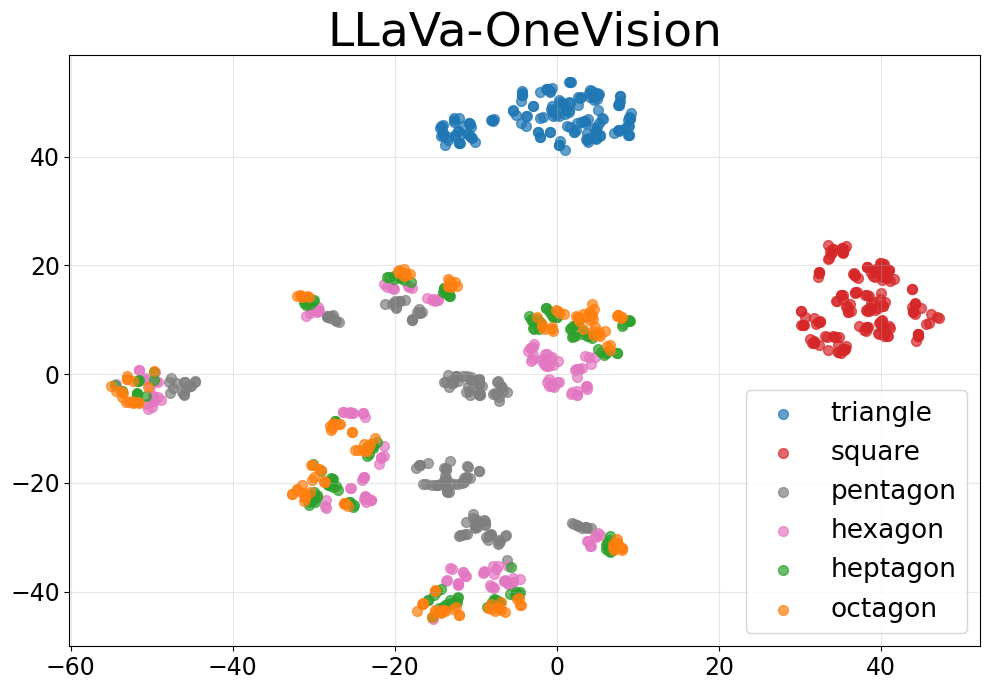

In [3]:
# THIS PLOTS EMBEDDINGS FOR ONE MODEL. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

# Set to TRUE if you need to make embeds. 
make_embeds = False
model_version = 'llava-one'

if not make_embeds:
    data, labels = load_embeddings(model_version)

if model_version == '1.5':
    model_name = 'LLaVA-1.5'
    
if model_version == '1.6':
    model_name = 'LLaVA-Next'

if model_version == 'qwen':
    model_name = "Qwen2-VL"
    
if model_version == 'internvl':
    model_name = "InternVL"

if model_version == 'llava-one':
    model_name = "LLaVa-OneVision"

if model_version == 'llama-3.2':
    model_name = "LLaMA-3.2"
    
    
if model_version == 'janus':
    model_name = "Janus-Pro"
    
    
if model_version == 'math-puma':
    model_name = "Math-PUMA"
    
    
if model_version == 'g-llava':
    model_name = "G-LLaVA"
    
print(model_version)
print(model_name)

tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)  # Shape: (7*162, 2)

# Define your custom labels and colors
shape_labels = ['triangle', 'square', 'pentagon', 'hexagon', 'heptagon', 'octagon']
color_labels = ['blue', 'red', 'gray', 'pink', 'green', 'orange']

# Fixed mapping between shape labels and colors
label_to_color = {
    'triangle': 'tab:blue',
    'square': 'tab:red',
    'pentagon': 'tab:gray',
    'hexagon': 'tab:pink',
    'heptagon': 'tab:green',
    'octagon': 'tab:orange'
}

# Visualization
plt.figure(figsize=(10, 7))

# Ensure the legend and colors always follow the same order
for label, color in label_to_color.items():
    # Filter data corresponding to the current label
    idx = labels == label  # This assumes `labels` contains 'circle', 'triangle', etc.
    plt.scatter(
        data_tsne[idx, 0], data_tsne[idx, 1],
        label=label,  # Use the shape label as the legend entry
        s=50, alpha=0.7, c=color
    )

# Add plot details
plt.title(f"{model_name}", fontsize=34)
plt.legend(fontsize=19)
plt.grid(alpha=0.3)

plt.xticks(fontsize=17) 
plt.yticks(fontsize=17)

plt.tight_layout()
plt.savefig("encoder_embeds.png")
plt.show()

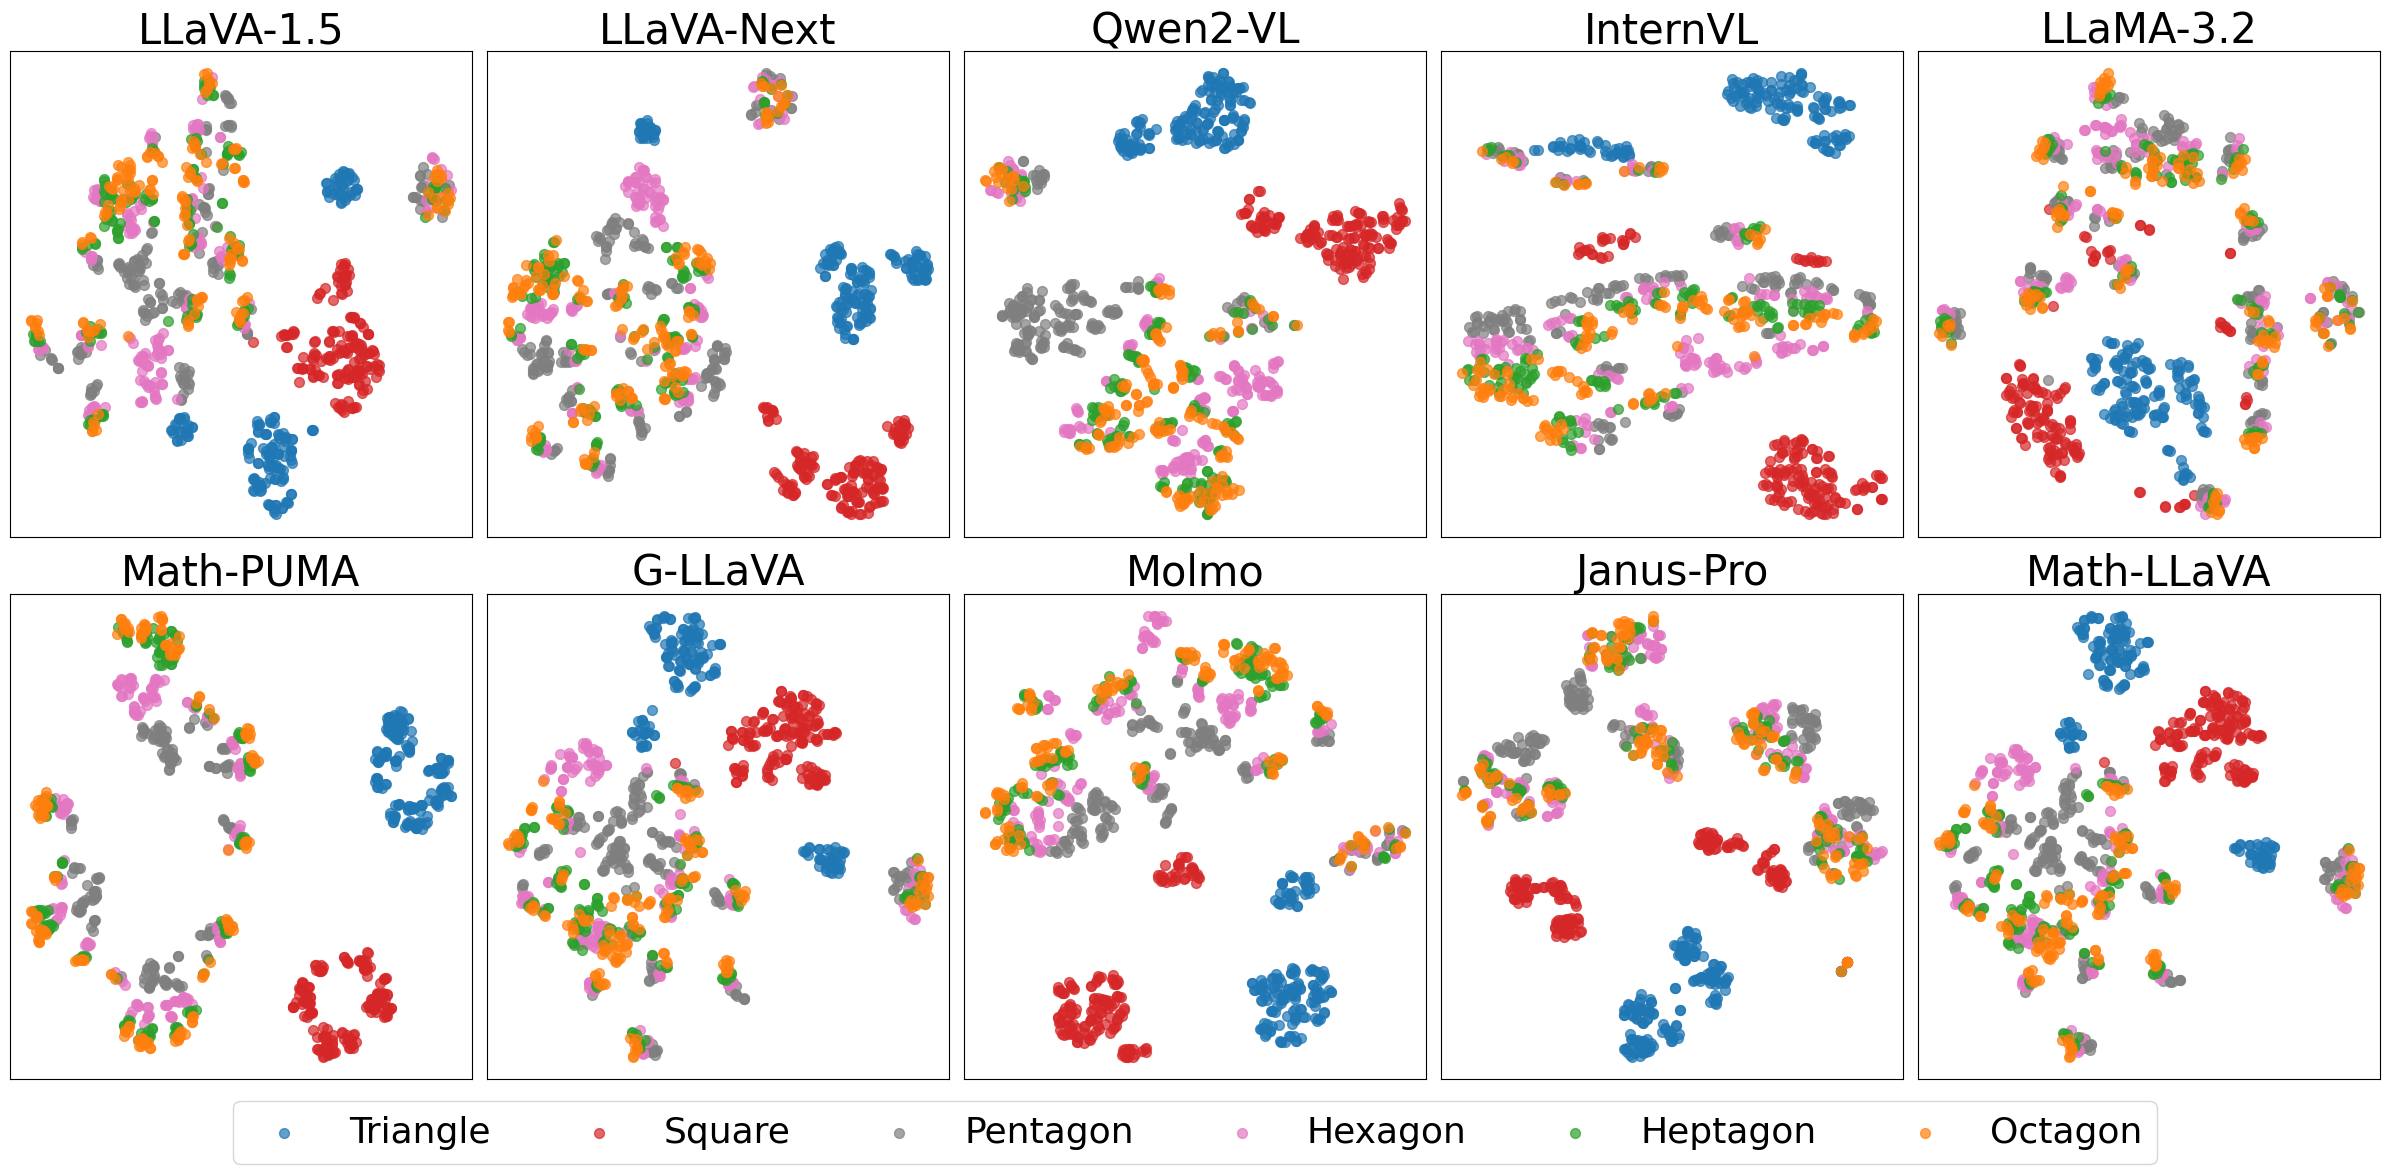

In [4]:
# THIS PLOTS EMBEDDINGS FOR ALL MODELS. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define model versions and their names
model_versions = ['1.5', '1.6', 'qwen', 'internvl', 'llama-3.2', 'math-puma', 'g-llava', 'molmo', 'janus', 'math-llava']
model_names = {
    '1.5': 'LLaVA-1.5',
    '1.6': 'LLaVA-Next',
    'qwen': "Qwen2-VL",
    'internvl': "InternVL",
    'llava-one': "LLaVA-OneVision",
    'llama-3.2': "LLaMA-3.2",
    'molmo': 'Molmo',
    'janus': 'Janus-Pro',
    'g-llava': 'G-LLaVA',
    'math-llava': 'Math-LLaVA',
    'math-puma': 'Math-PUMA'
}

# Define shape labels and fixed color mapping
shape_labels = ['Triangle', 'Square', 'Pentagon', 'Hexagon', 'Heptagon', 'Octagon']
label_to_color = {
    'triangle': 'tab:blue',
    'square': 'tab:red',
    'pentagon': 'tab:gray',
    'hexagon': 'tab:pink',
    'heptagon': 'tab:green',
    'octagon': 'tab:orange'
}

# Create a 2x3 figure
fig, axes = plt.subplots(2, 5, figsize=(24, 11))
axes = axes.flatten()  # Flatten to easily iterate over 2D subplots

# Loop through each model version
for i, model_version in enumerate(model_versions):
    # Load data and labels
    data, labels = load_embeddings(model_version)
    
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    data_tsne = tsne.fit_transform(data)

    # Get model name
    model_name = model_names[model_version]
    
    # Plot on corresponding subplot
    ax = axes[i]
    for label, color in label_to_color.items():
        idx = labels == label
        ax.scatter(data_tsne[idx, 0], data_tsne[idx, 1], label=label, s=50, alpha=0.7, c=color)
    
    ax.set_title(model_name, fontsize=30)
   
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(alpha=0.2)
    
handles, labels = axes[0].get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
fig.legend(handles, labels, loc='lower center', fontsize=26, ncol=len(labels), bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()

plt.savefig("vision_tsne_plot.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

# NN Purity Analysis

In [10]:
from sklearn.neighbors import NearestNeighbors

def get_nn_purity(data, labels):
    nn_purity = {}
    n_neighbors = 20

    for target_label in ['triangle', 'square', 'pentagon', 'hexagon', 'heptagon', 'octagon']:

        # Step 1: Get indices of points with the target label
        target_indices = np.where(labels == target_label)[0]
        target_data = data[target_indices]

        # Step 2: Use NearestNeighbors to find nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm='auto').fit(data)  # +1 to exclude the point itself
        distances, indices = nbrs.kneighbors(target_data)

        # Step 3: Calculate purity for each target point
        purity_scores = []
        for i, neighbors in enumerate(indices):
            # Exclude the point itself from neighbors
            neighbors = neighbors[1:]  # Skip the first neighbor (itself)
            neighbor_labels = labels[neighbors]

            # Compute the fraction of neighbors with the same label
            same_label_count = np.sum(neighbor_labels == target_label)
            purity_scores.append(same_label_count / n_neighbors)

        # Step 4: Aggregate results
        average_purity = np.mean(purity_scores)

        print(f"Average Purity for label '{target_label}': {average_purity}")
        nn_purity[target_label] = average_purity
    print('-------------------------------------------------------')
    return nn_purity

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define model versions and their names
model_versions = ['math-puma', '1.5', '1.6', 'qwen', 'internvl', 'llava-one', 'llama-3.2', 'g-llava', 'molmo', 'janus', 'math-llava']
model_names = {
    '1.5': 'LLaVA-1.5',
    '1.6': 'LLaVA-1.6',
    'qwen': "Qwen-VL",
    'internvl': "InternVL",
    'llava-one': "LLaVA-One",
    'llama-3.2': "LLaMA-3.2",
    'molmo': 'Molmo',
    'janus': 'Janus-Pro',
    'g-llava': 'G-LLaVA',
    'math-llava': 'Math-LLaVA',
    'math-puma': 'Math-PUMA'
}

all_purity = {}

# Loop through each model version
for i, model_version in enumerate(model_versions):
    # Load data and labels
    data, labels = load_embeddings(model_version)
    
    purity = get_nn_purity(data, labels)
    all_purity[model_names[model_version]] = purity

Average Purity for label 'triangle': 0.9993827160493828
Average Purity for label 'square': 1.0
Average Purity for label 'pentagon': 0.7549382716049382
Average Purity for label 'hexagon': 0.5682098765432099
Average Purity for label 'heptagon': 0.5070987654320988
Average Purity for label 'octagon': 0.5055555555555555
-------------------------------------------------------
Average Purity for label 'triangle': 0.9515432098765433
Average Purity for label 'square': 0.9524691358024692
Average Purity for label 'pentagon': 0.652469135802469
Average Purity for label 'hexagon': 0.5021604938271605
Average Purity for label 'heptagon': 0.4410493827160494
Average Purity for label 'octagon': 0.4780864197530864
-------------------------------------------------------
Average Purity for label 'triangle': 0.9854938271604938
Average Purity for label 'square': 0.9688271604938271
Average Purity for label 'pentagon': 0.6604938271604939
Average Purity for label 'hexagon': 0.5762345679012345
Average Purity for 